In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torch
import numpy as np

# Dataset

In [3]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

AAAAAAA data True data\tickers.csv True
Chosen tickers: ['LKOH', 'SBER', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


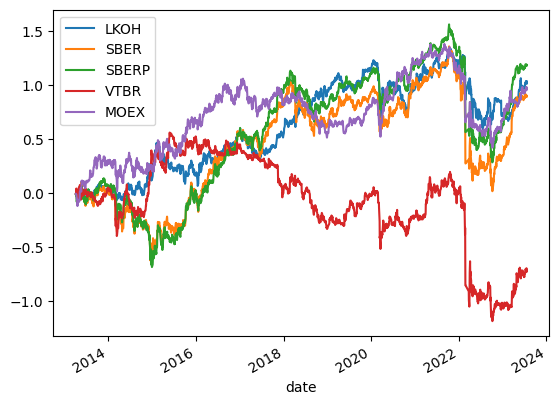

In [4]:
df_returns_real.cumsum().plot()
plt.show()

# GAN TCN


In [5]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [6]:
from gan import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


## Train

50 epochs train time: 482.5s. Estimated train time: 32.2m
Fake std: [0.02790814 0.0235179  0.02169286 0.02565646 0.02313255].
Real std: [0.02243834 0.01917073 0.02287722 0.02141348 0.0187115 ]
Fake correlation: 0.7512544563103505. Real correlation: 0.9197504933566062


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\код максима\aa\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\код максима\aa\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


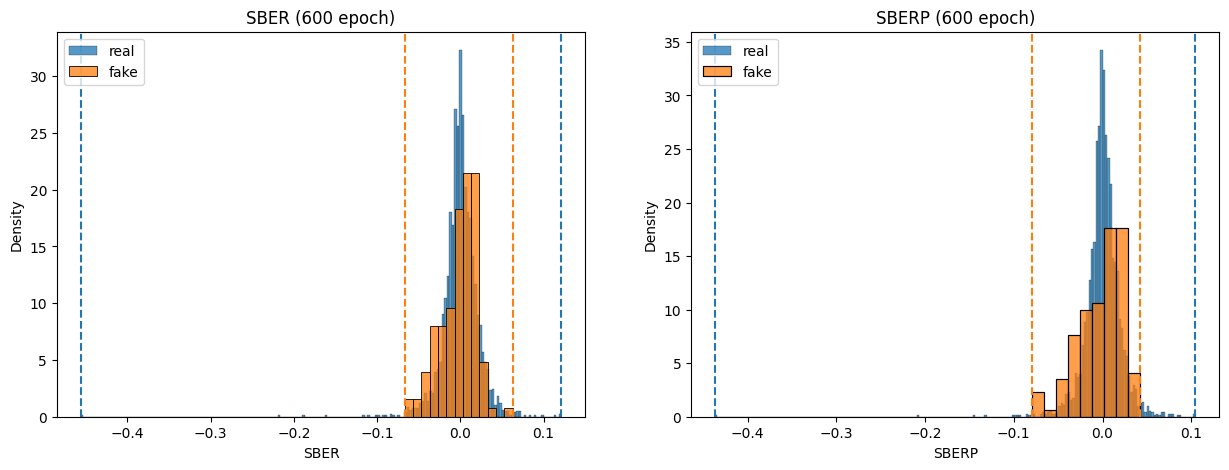

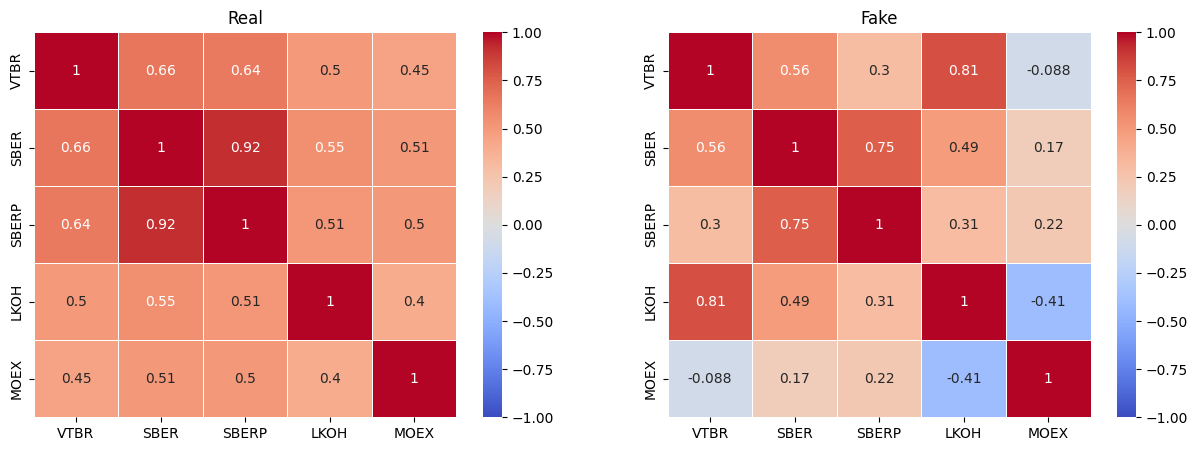

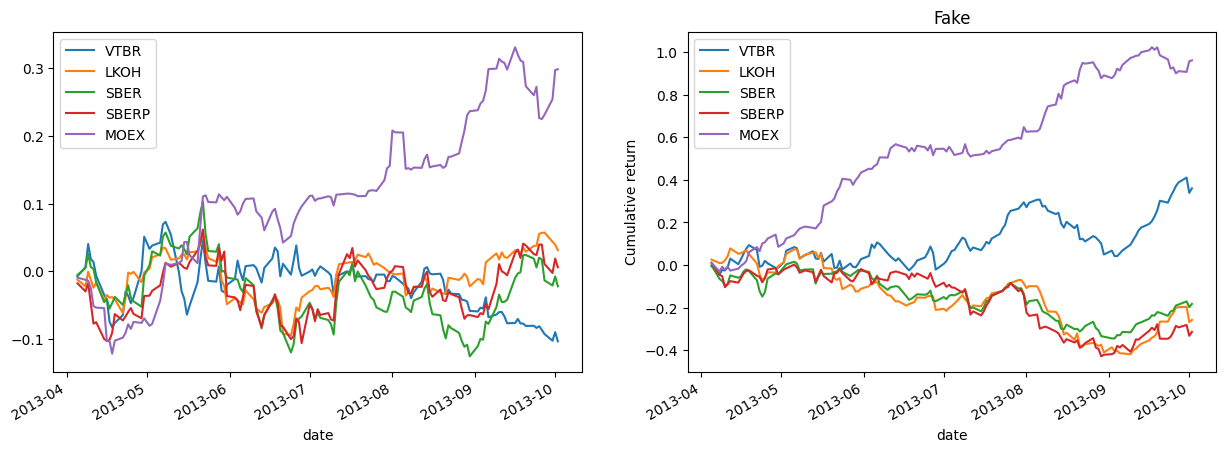

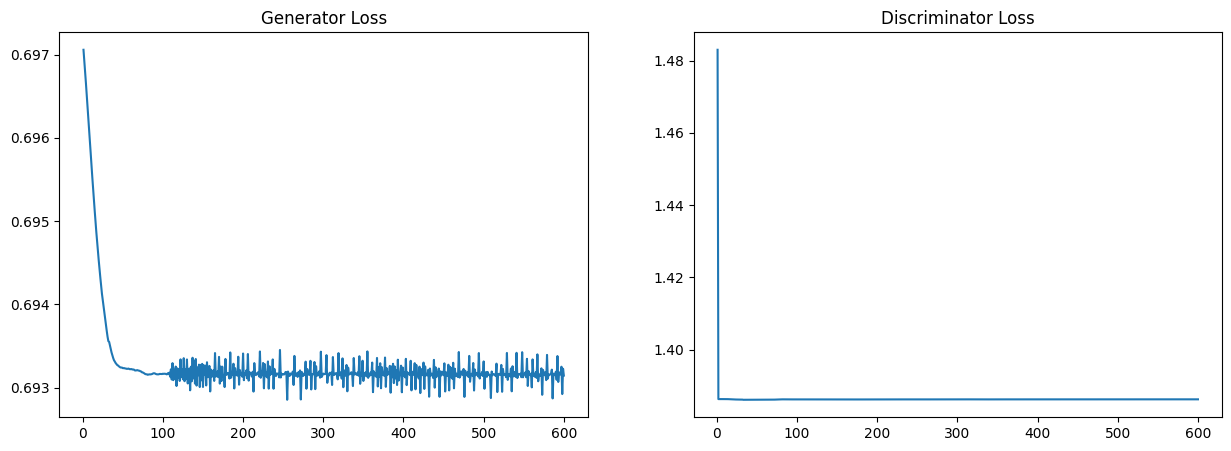

In [ ]:
from gan_train_loop import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 50
SAVE_FREQUENCY = 200

# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses, generator_losses = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='TCN')

In [ ]:
plt.plot(generator_losses[10:])
plt.show()
plt.plot(discriminator_losses[10:])
plt.show()

# Generation

## Generate random history

In [9]:
from gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=800)

Load 800 epoch and 2 kernek_size checkpoint


In [10]:
Generator()

Generator(
  (tcn): ModuleList(
    (0): TemporalBlock(
      (conv1): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(10, 10, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(10, 10, kernel_size=(2,), stride=(1,), padd

In [11]:
from generation import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

(2576, 5)
tensor(-0.0230)


## Plot cumulative real and fake returns

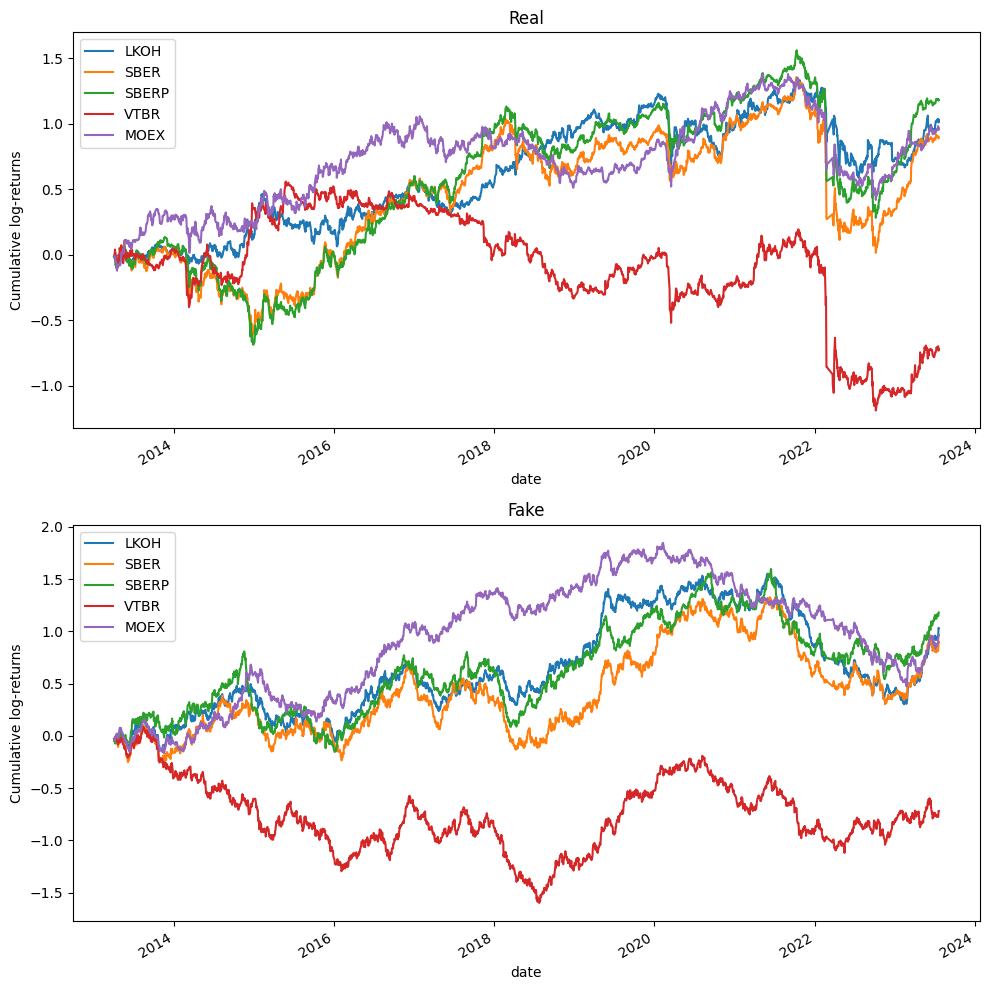

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

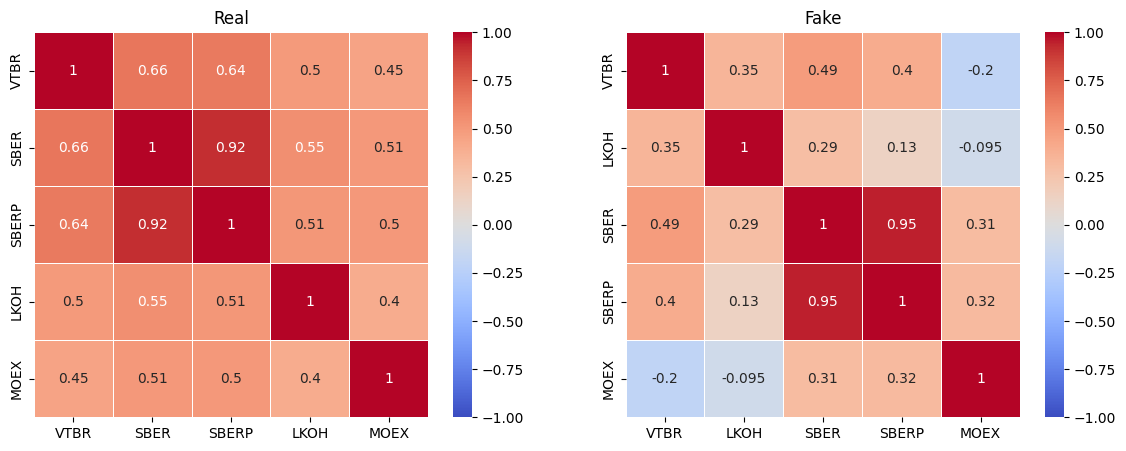

In [23]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

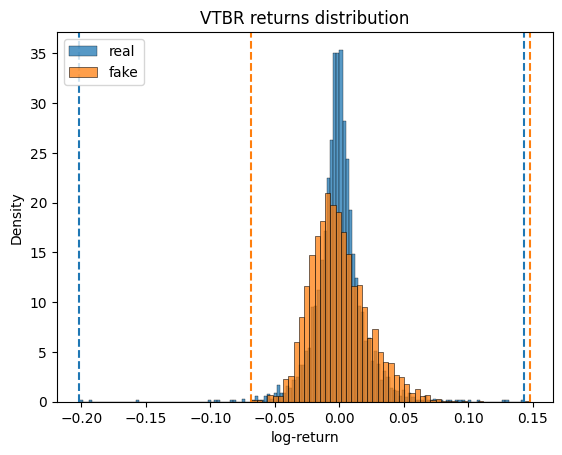

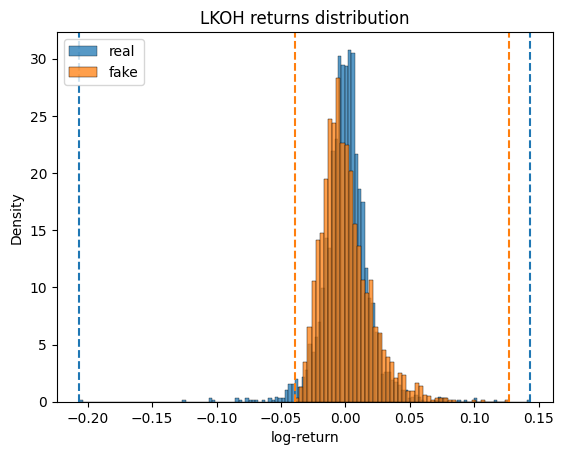

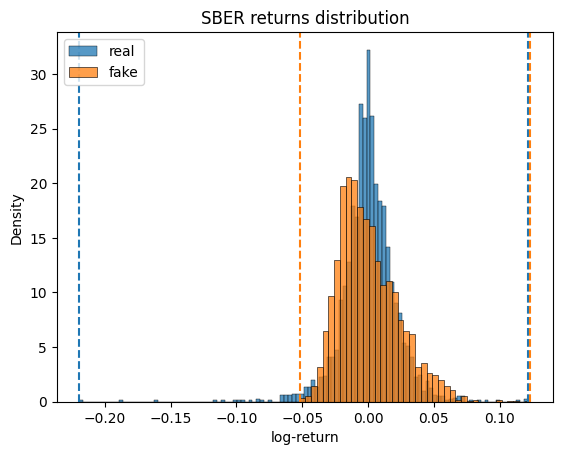

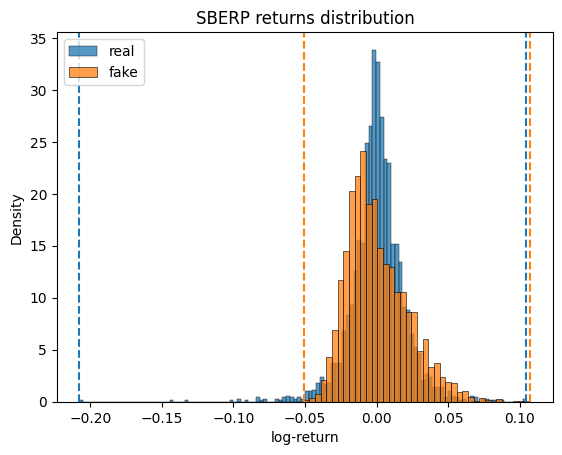

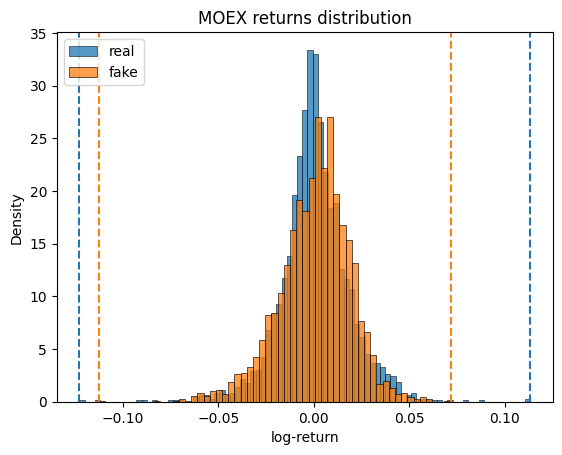

In [24]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()

# GAN MLP

In [5]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

AAAAAAA data True data\tickers.csv True
Chosen tickers: ['LKOH', 'SBER', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


In [6]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [7]:
from gan_MLP import Discriminator, Generator


assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [8]:
Generator()

Generator(
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=1260, out_features=100, bias=True)
      (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=630, bias=True)
    )
    (relu): ReLU()
  )
)

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


  0%|          | 0/800 [00:00<?, ?it/s]

100 epochs train time: 94.5s. Estimated train time: 11.0m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.06640016 0.06435665 0.07747927 0.06955632 0.06616204].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.17347873595701177. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


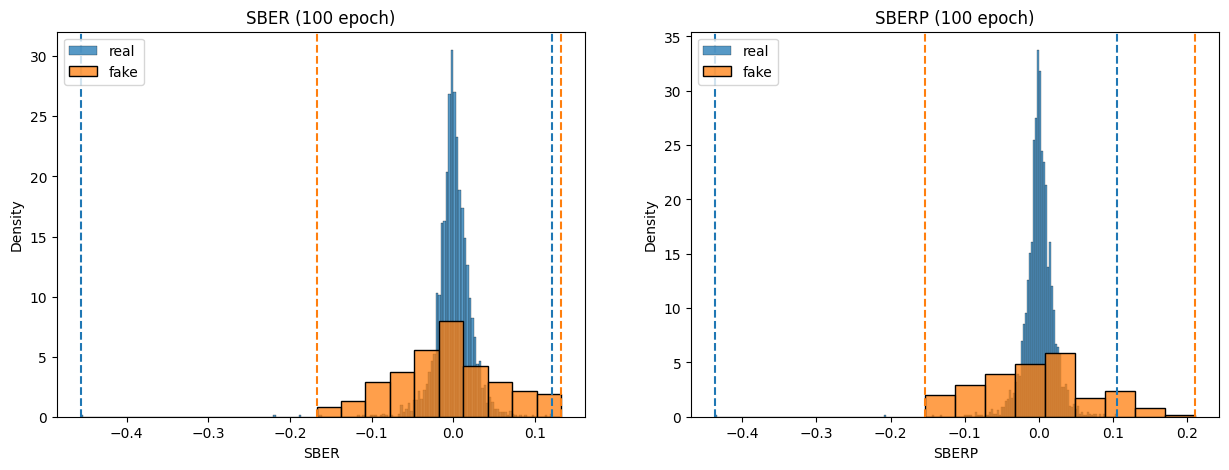

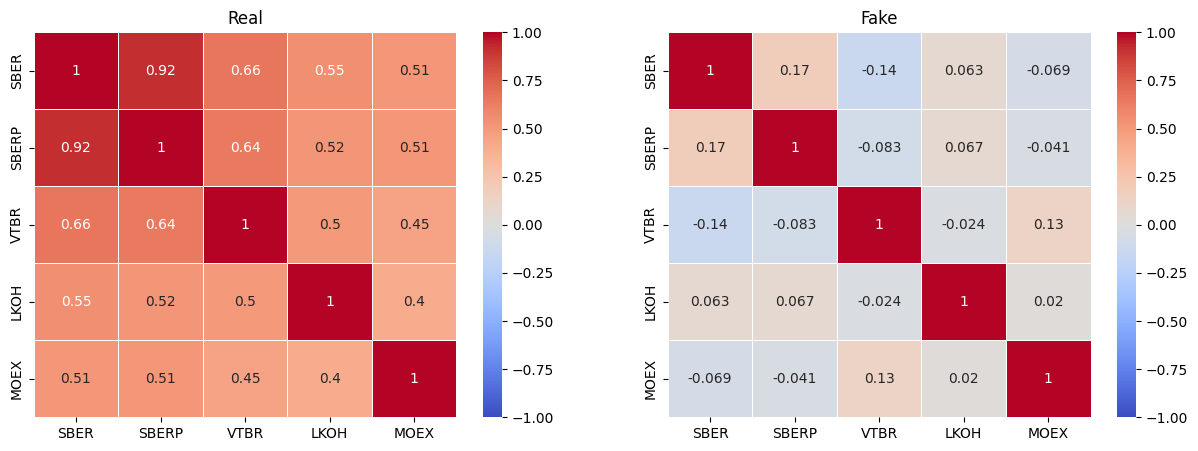

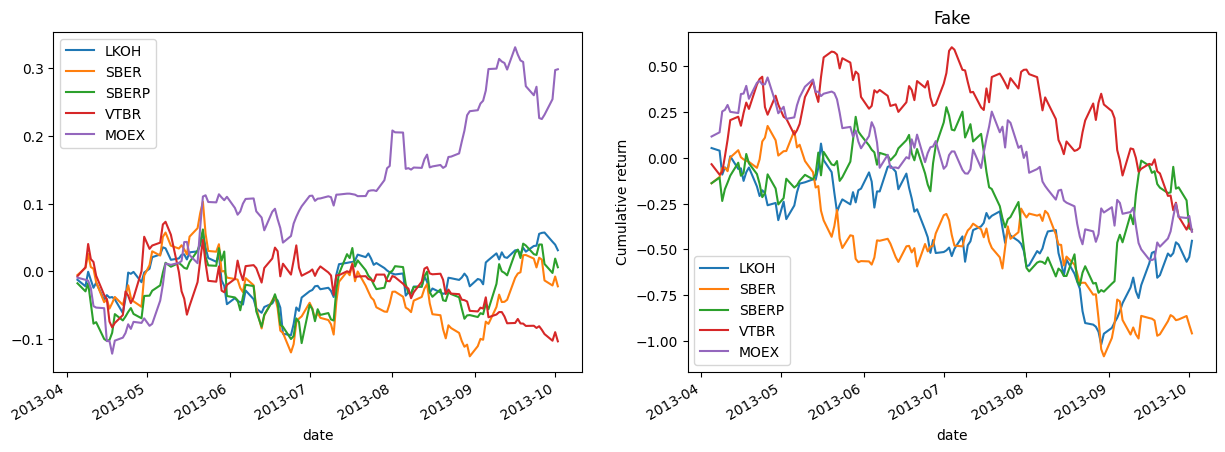

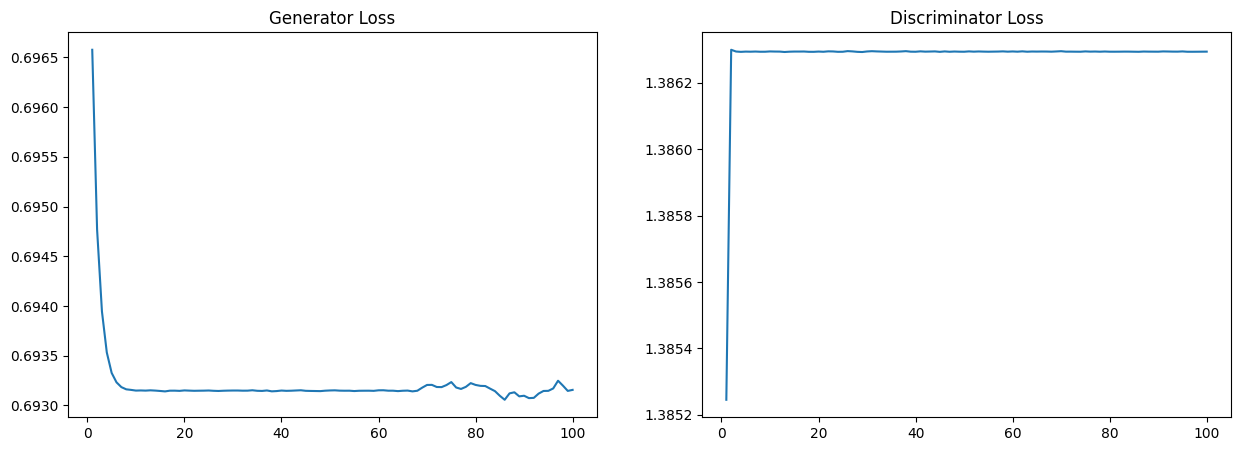

100 epochs train time: 121.6s. Estimated train time: 12.2m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.0548089  0.03801974 0.03910631 0.05268354 0.05074282].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.08369674536652072. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


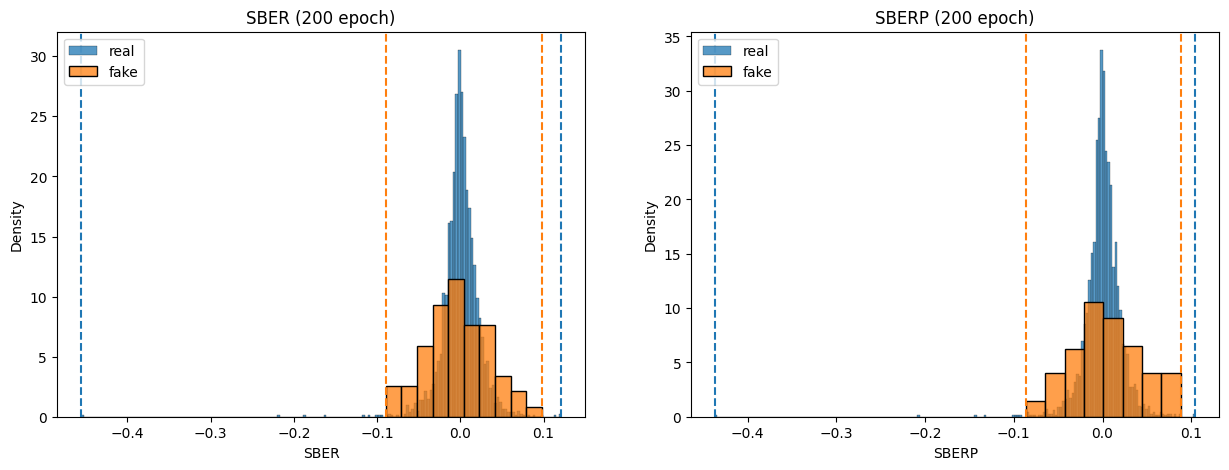

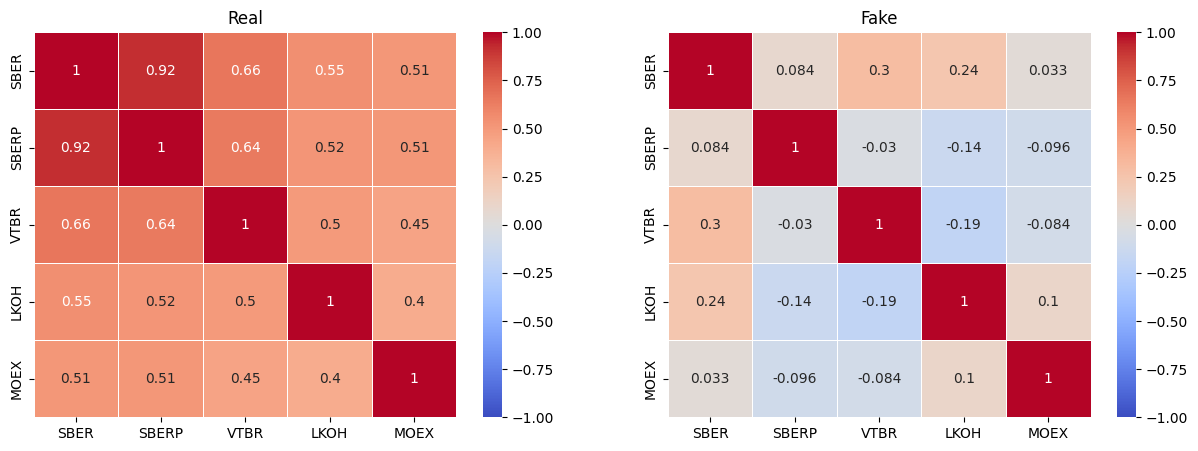

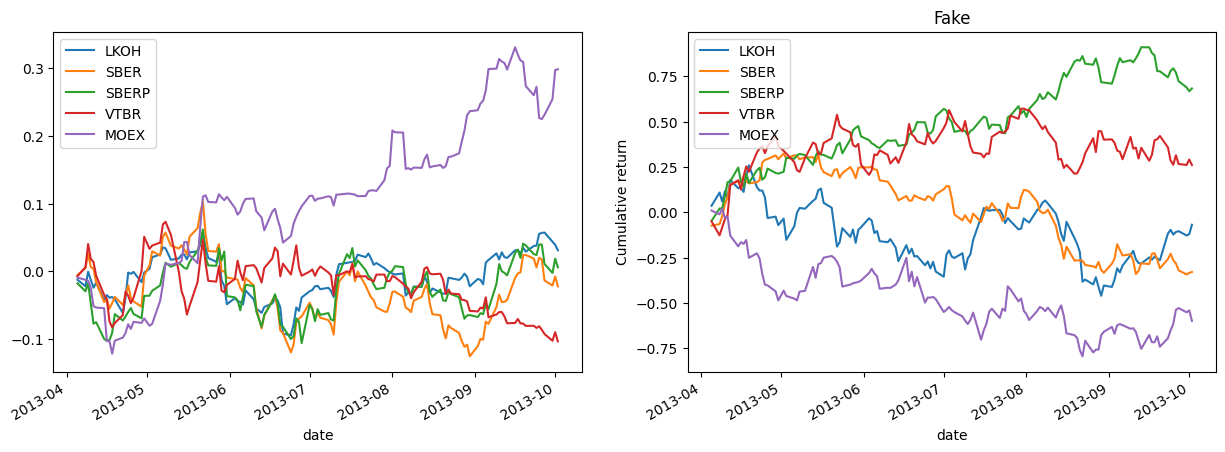

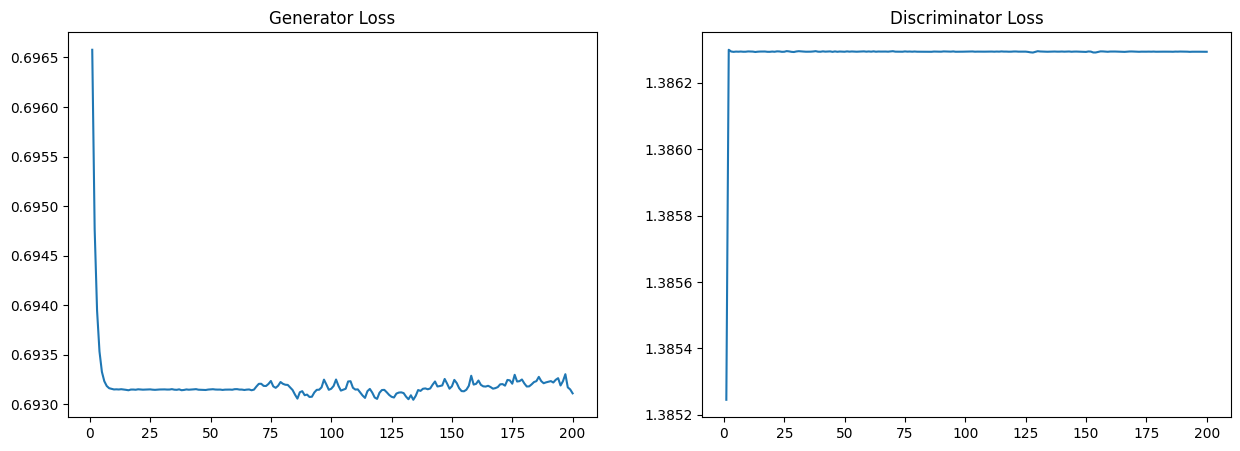

100 epochs train time: 127.3s. Estimated train time: 10.6m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.02903249 0.02428608 0.02758446 0.02391928 0.03142457].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.26538247361720557. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


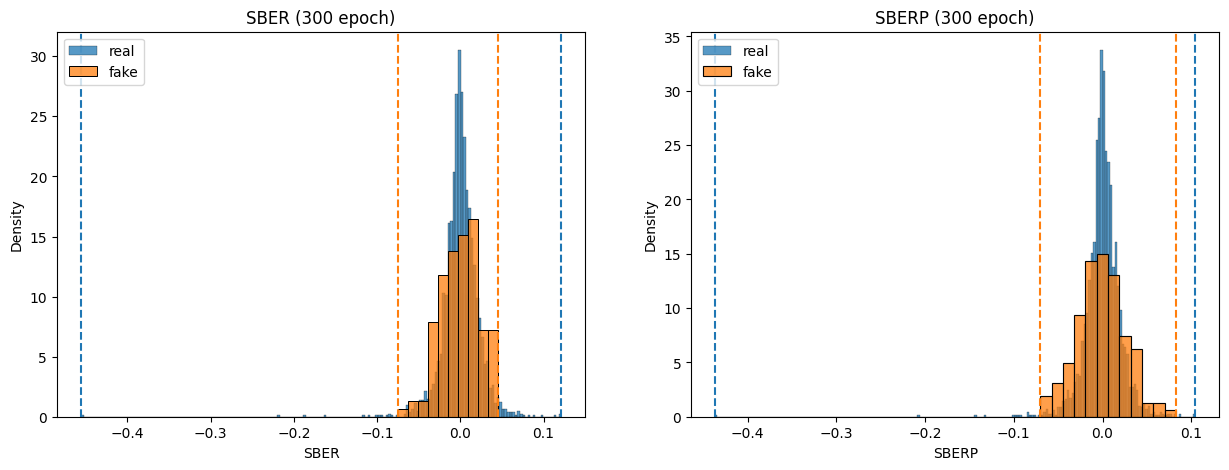

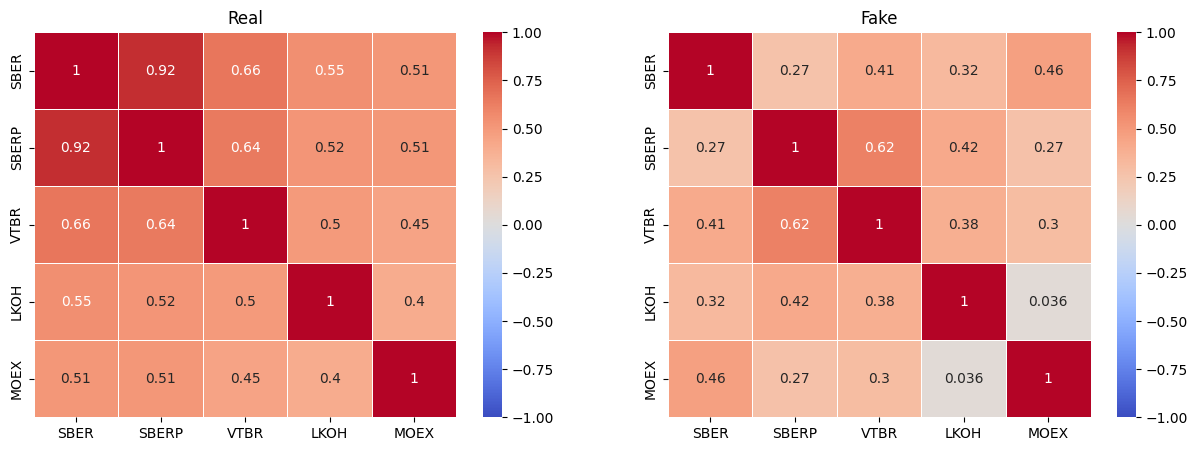

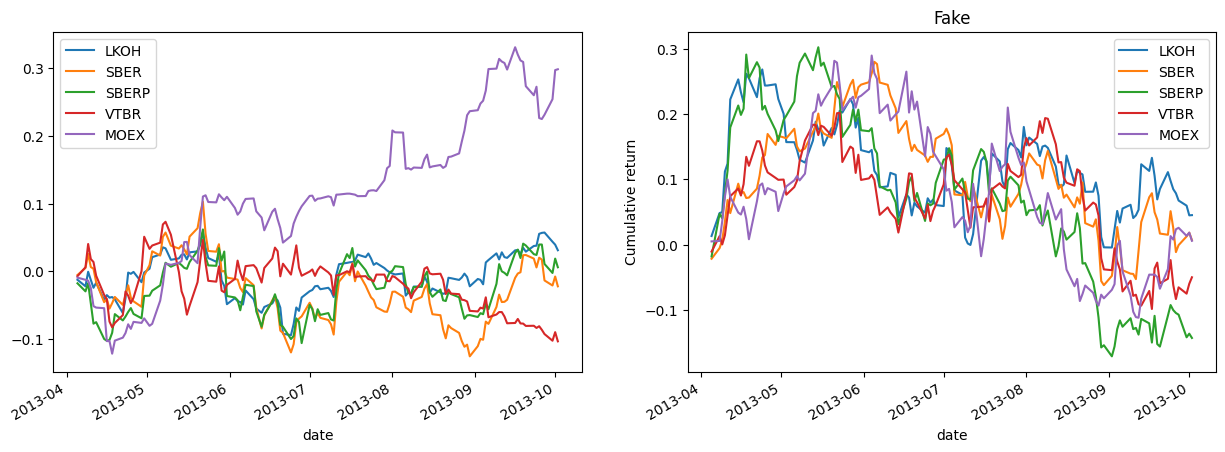

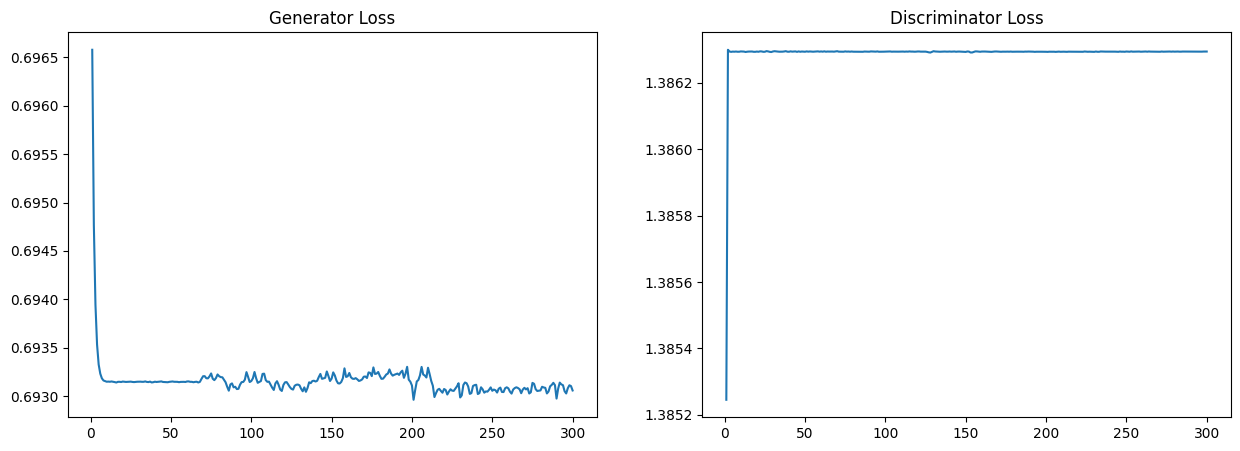

100 epochs train time: 128.3s. Estimated train time: 8.6m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.0304909  0.02839518 0.02936154 0.02772742 0.03312456].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.4638988393744559. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


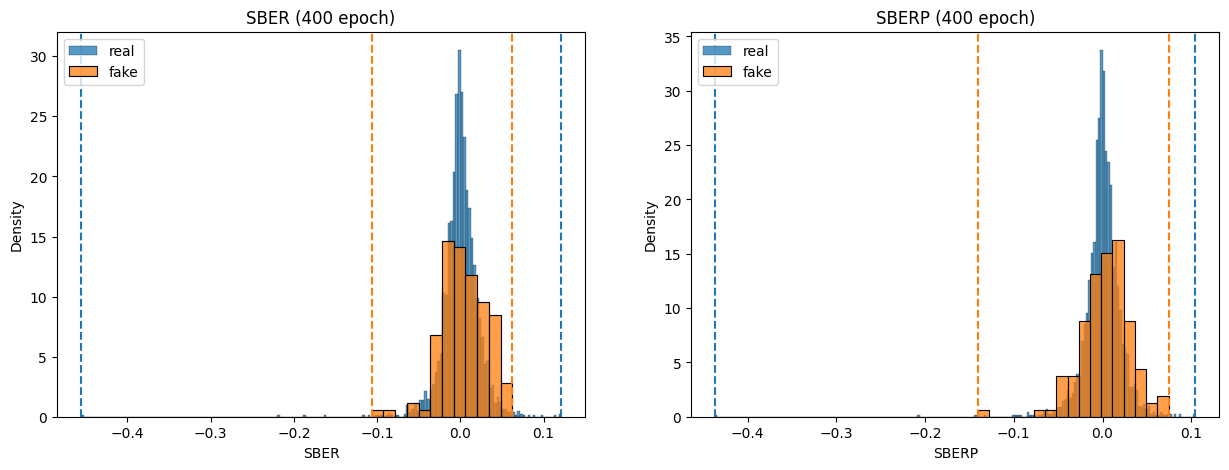

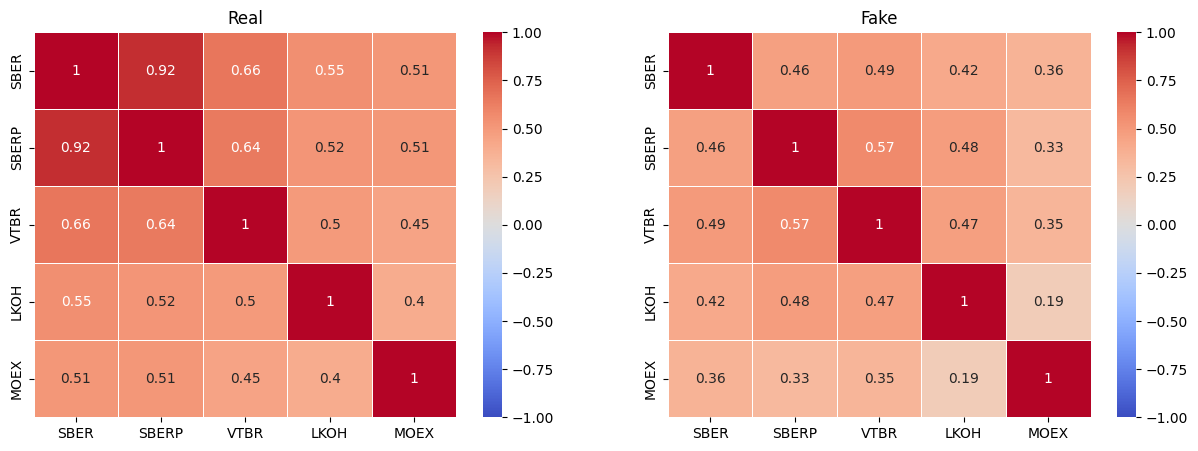

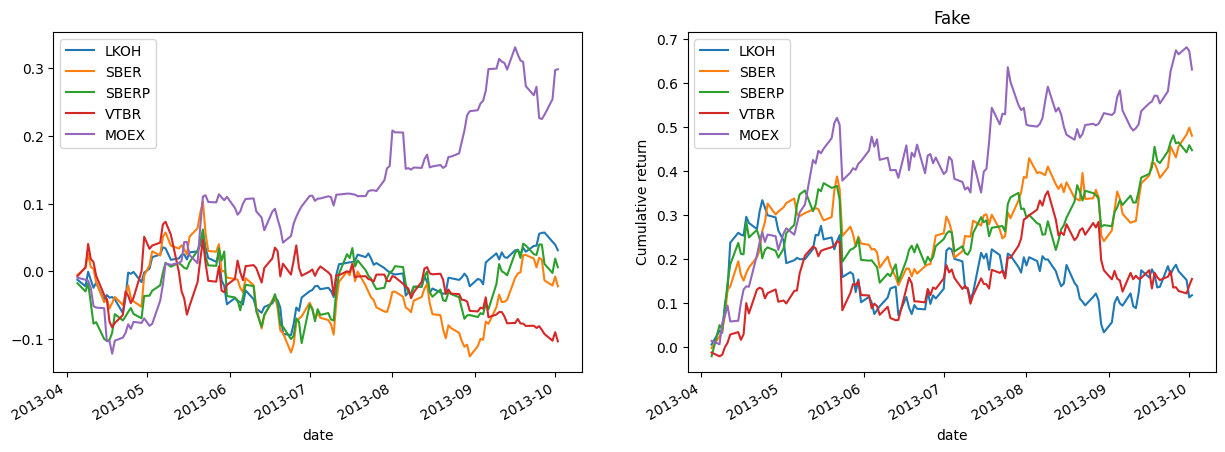

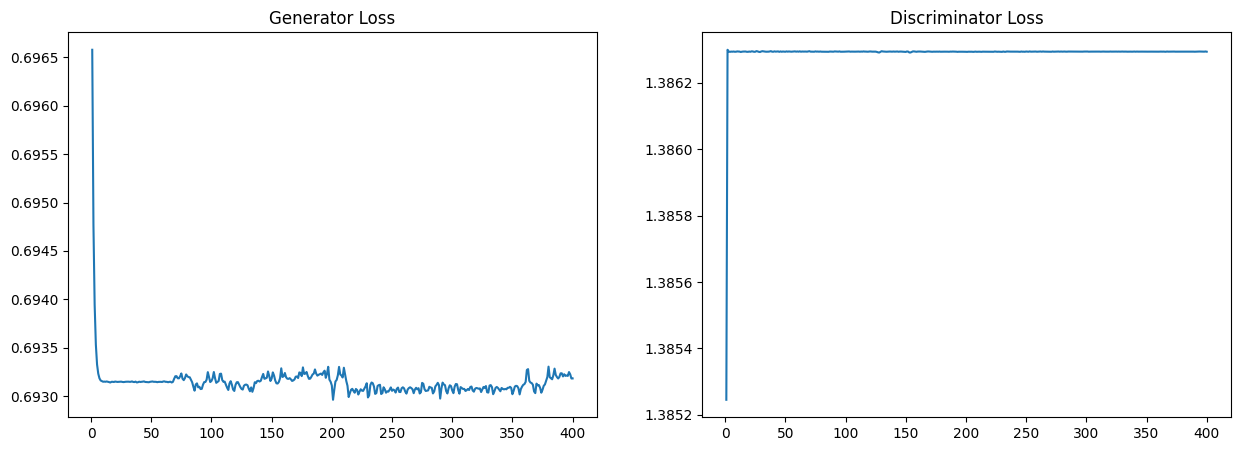

100 epochs train time: 124.7s. Estimated train time: 6.2m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.03337023 0.02994734 0.03302495 0.03176526 0.03494733].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.5385923991182899. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


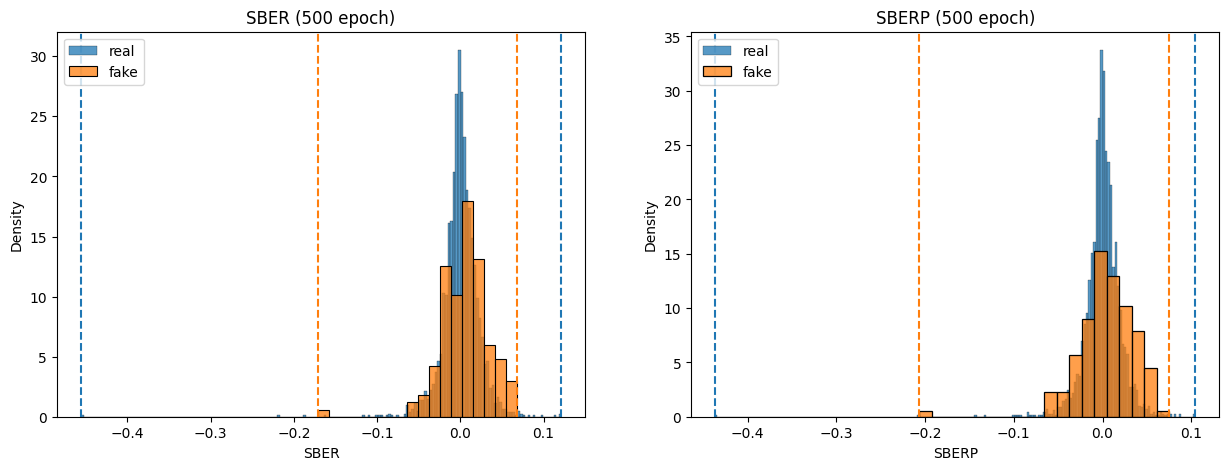

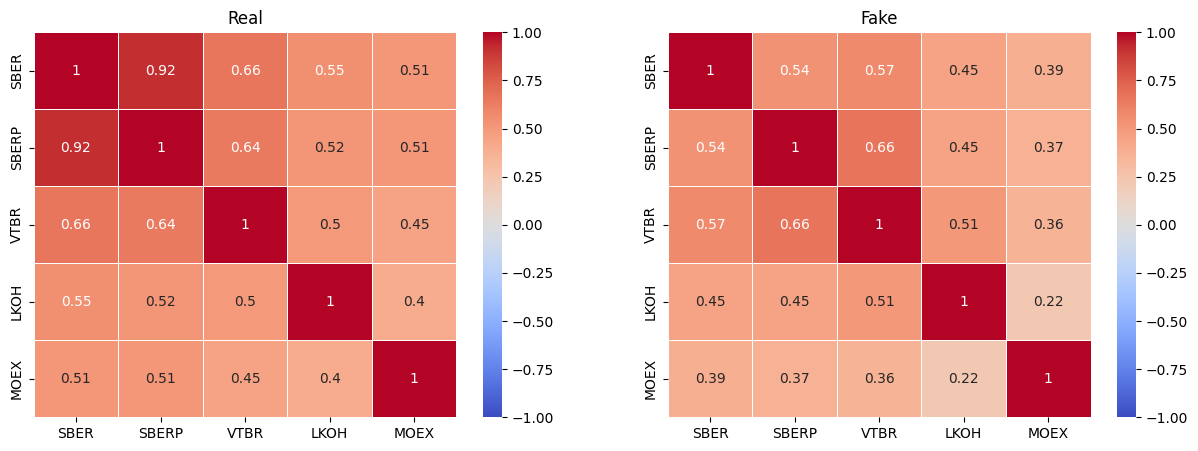

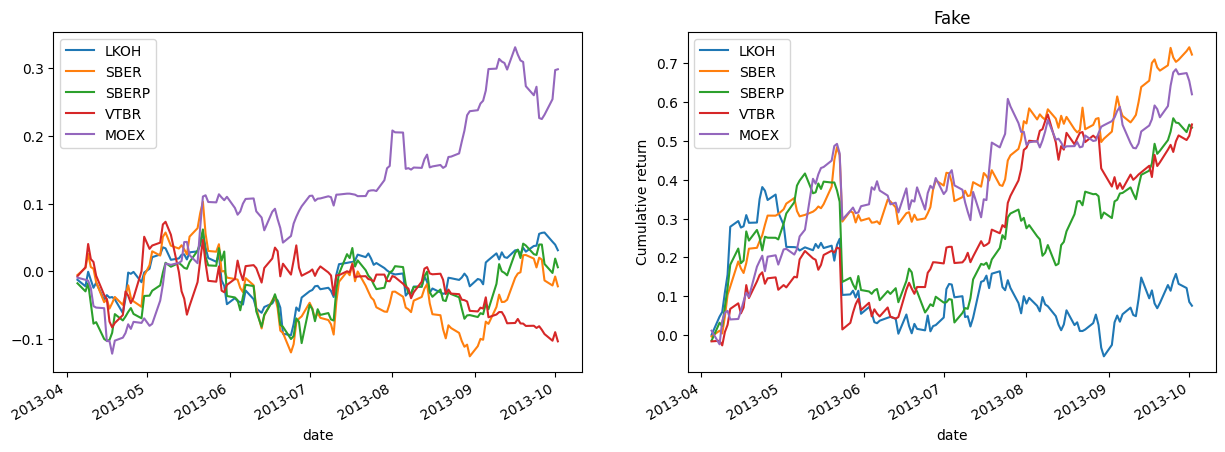

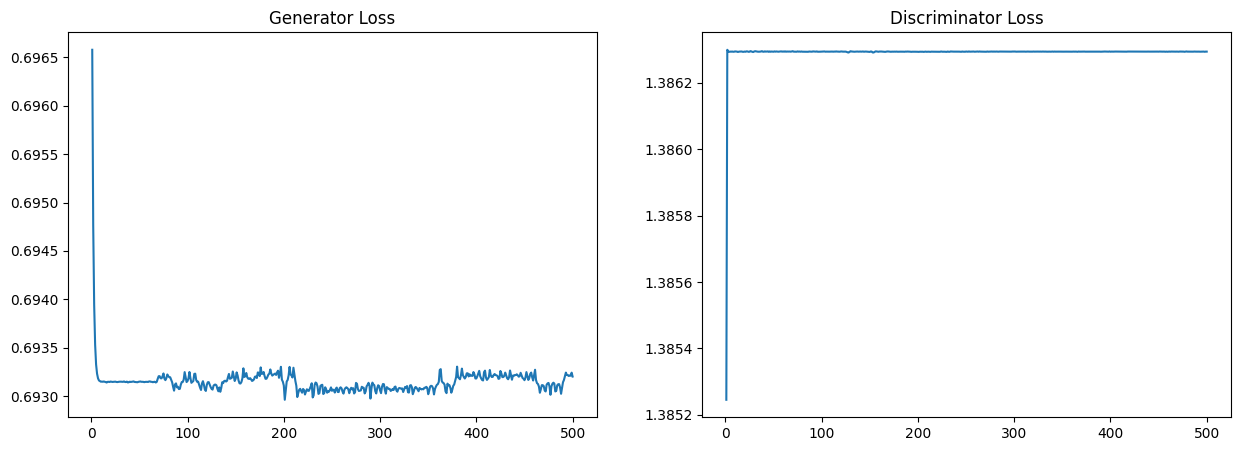

100 epochs train time: 129.8s. Estimated train time: 4.3m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.03926178 0.03774983 0.04358645 0.04435303 0.0407625 ].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.528819817259546. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


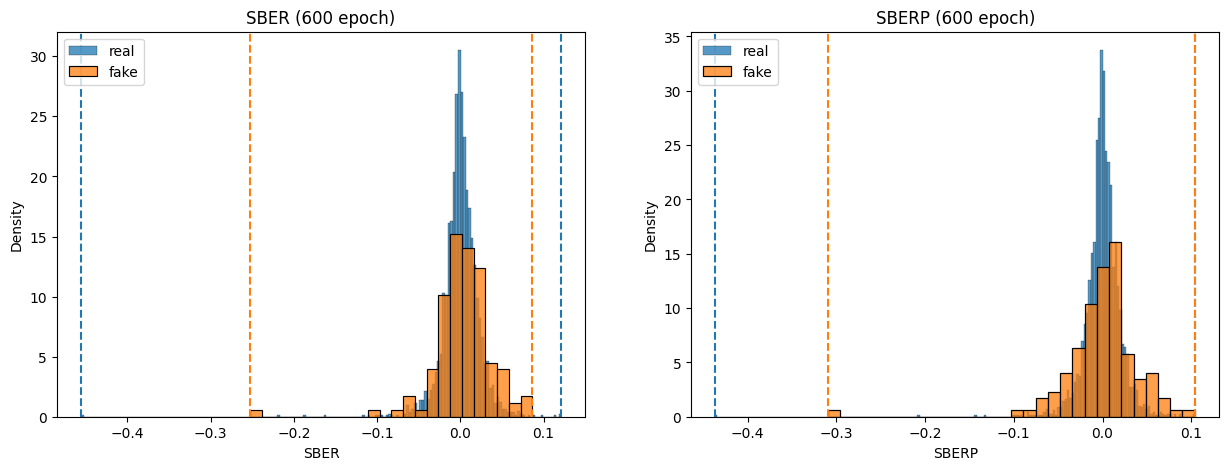

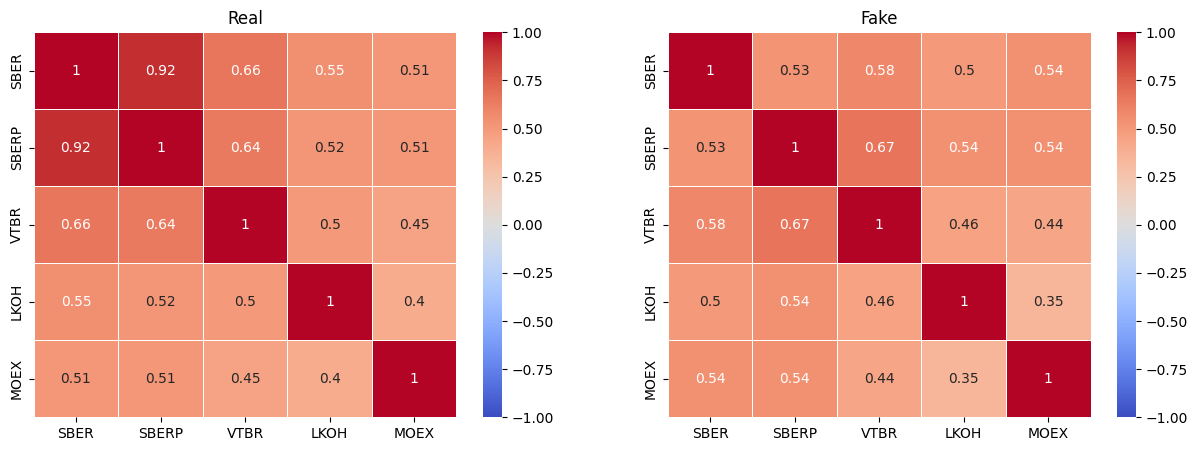

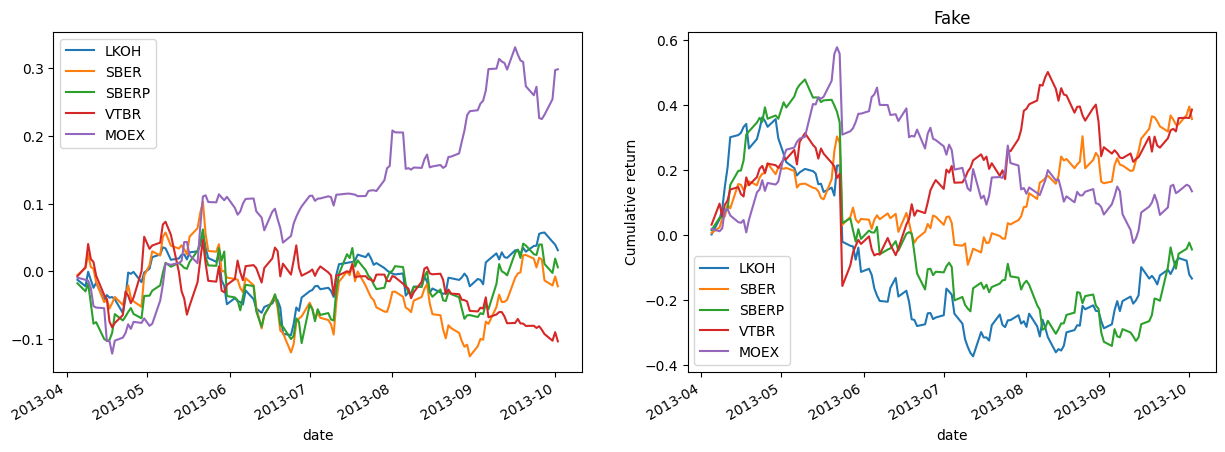

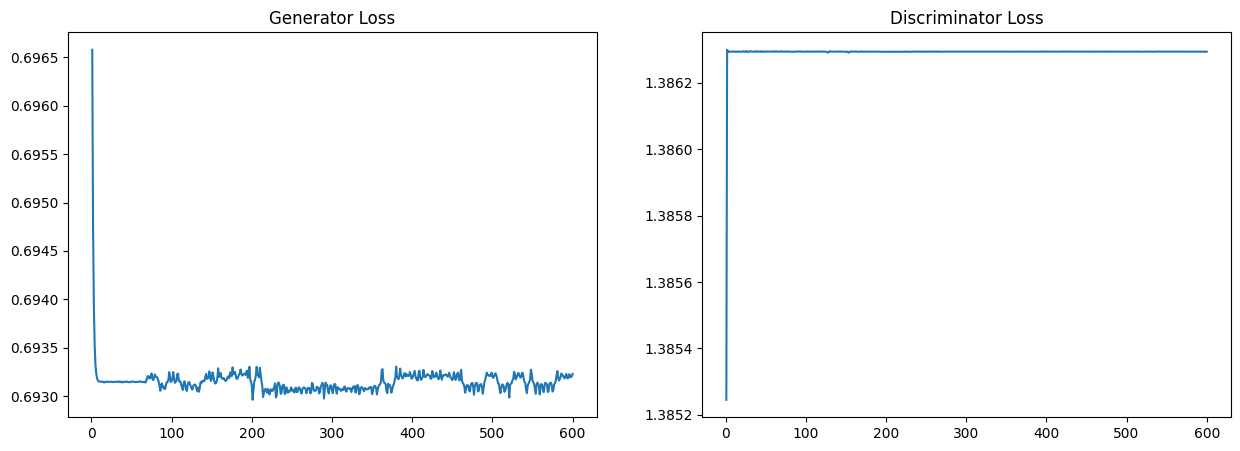

100 epochs train time: 129.2s. Estimated train time: 2.2m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.03271538 0.02923353 0.02889277 0.03028013 0.03272701].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.13533079074341675. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


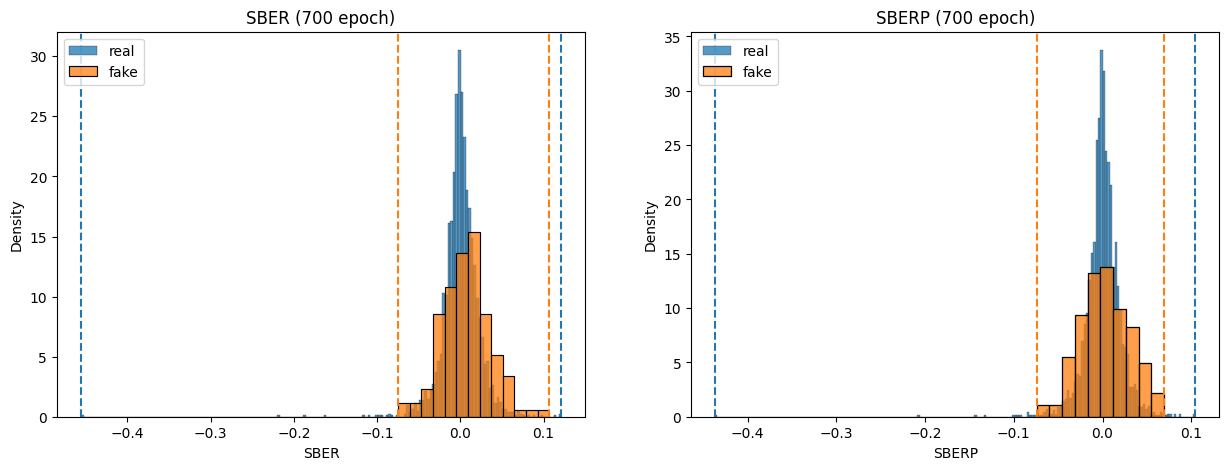

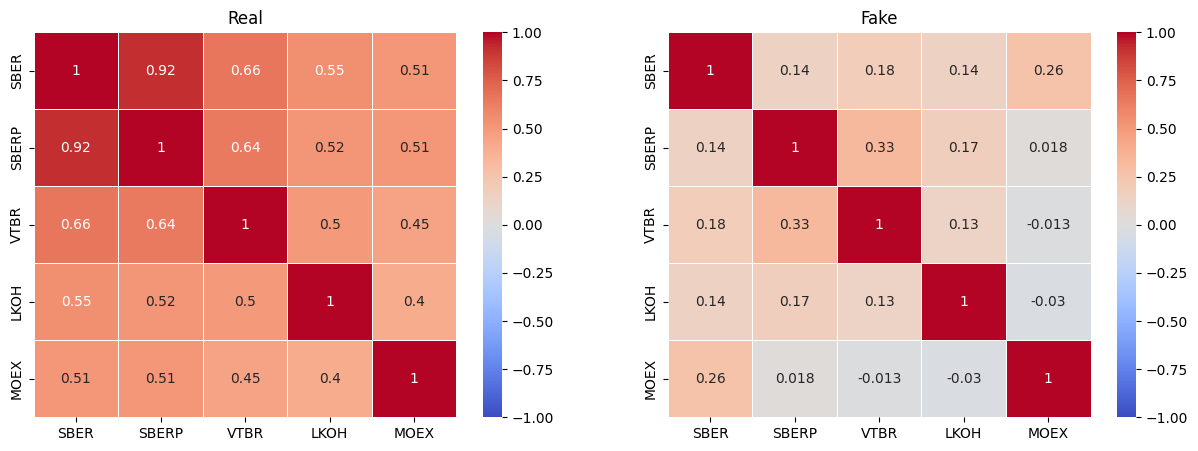

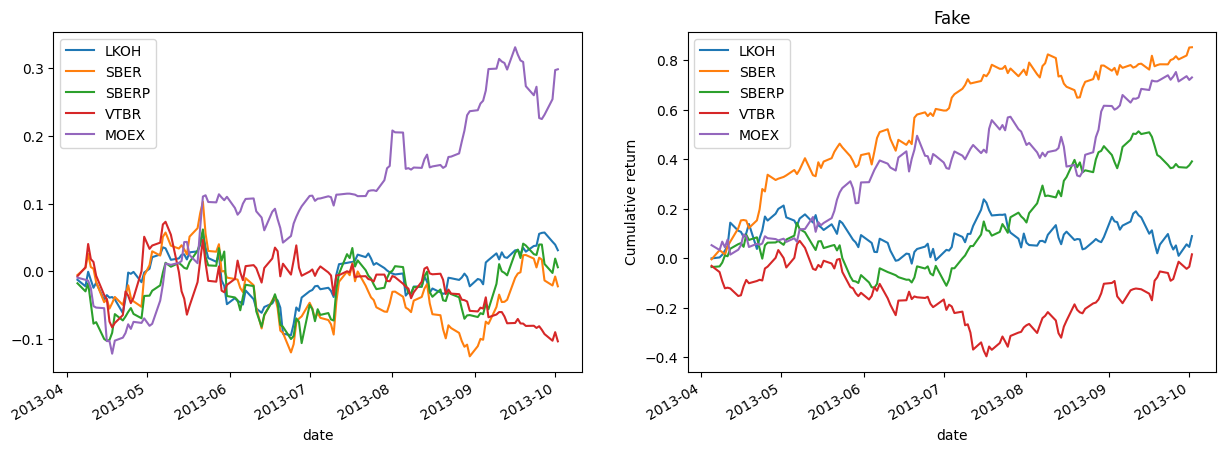

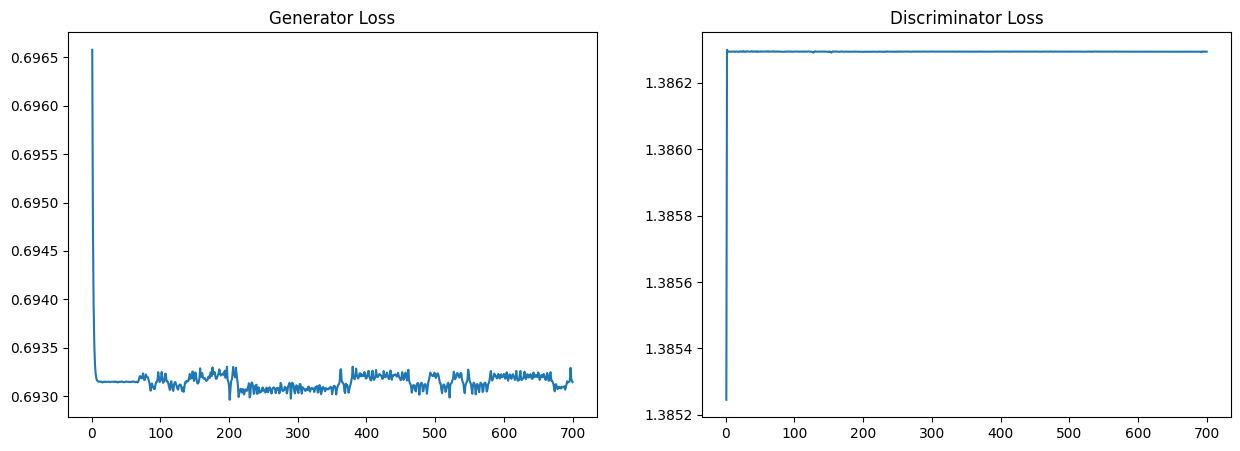

100 epochs train time: 132.7s. Estimated train time: 0.0m
n_samples, samples.shape 1 torch.Size([1, 5, 126])
Fake std: [0.02908672 0.02570983 0.02629839 0.02392819 0.02731341].
Real std: [0.01934618 0.02320357 0.02170969 0.02256658 0.01871406]
Fake correlation: 0.13495291069477222. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


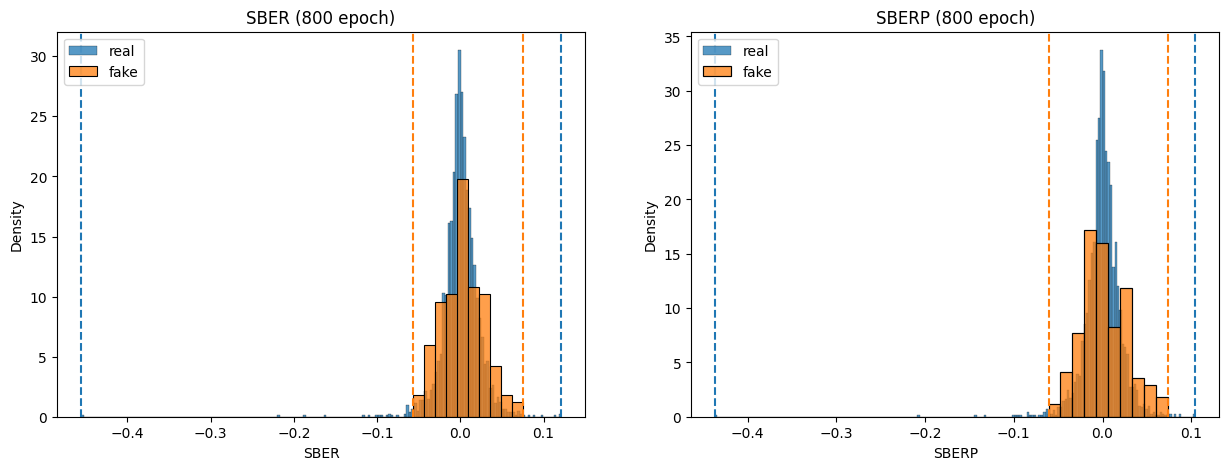

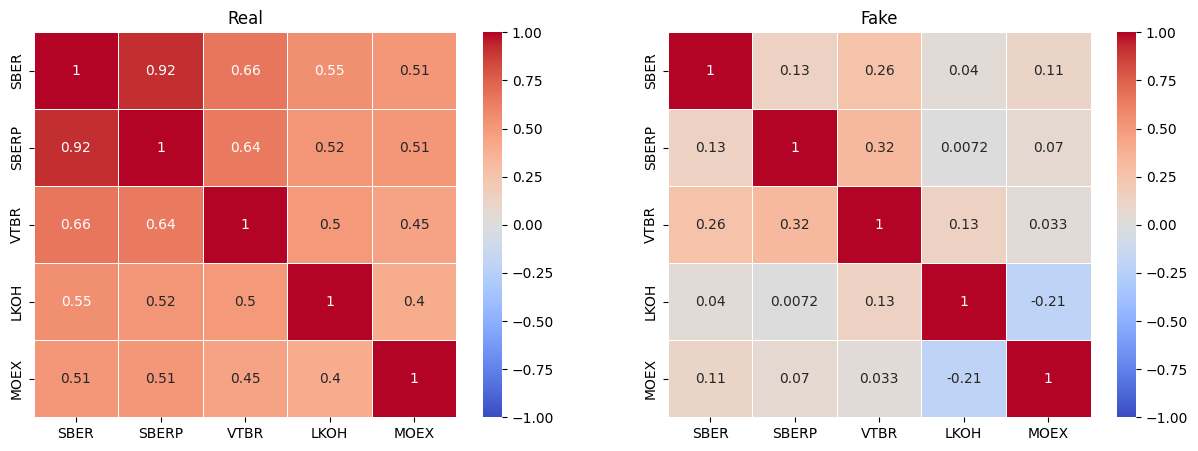

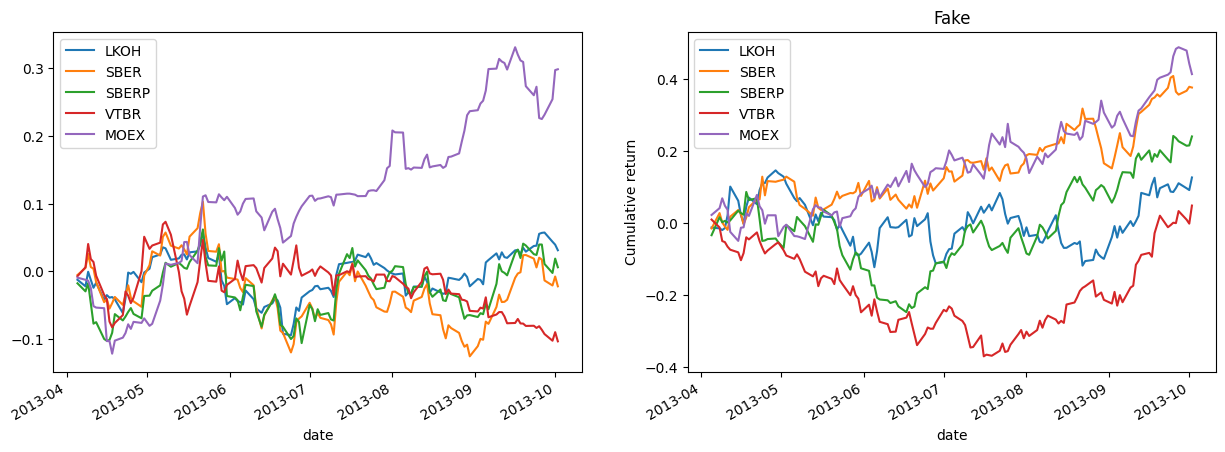

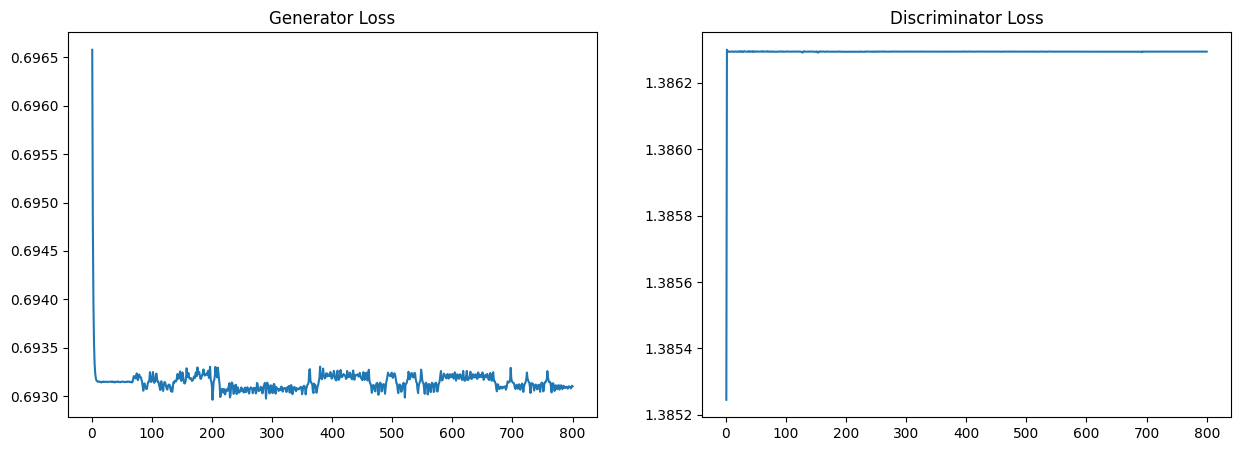

In [14]:
from gan_train_loop_MLP import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 100
SAVE_FREQUENCY = 100

torch.manual_seed(1) # добавил, чтобы генерации были одинаковыми
# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses_mlp, generator_losses_mlp = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='MLP')

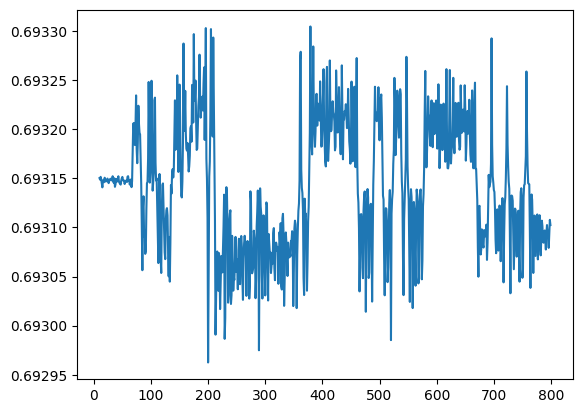

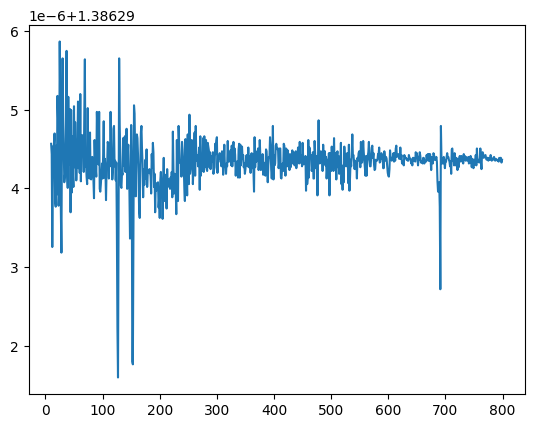

In [19]:
plt.plot(range(10, len(discriminator_losses_mlp)), discriminator_losses_mlp[10:])
plt.show()
plt.plot(range(10, len(generator_losses_mlp)), generator_losses_mlp[10:])
plt.show()

# Generate rand history

In [20]:
from gan_train_loop_MLP import load_gan

generator = Generator().to(DEVICE)
load_gan('MLP', generator, epoch=500)

models\MLP
Load 500 epoch checkpoint
models\MLP\checkpoint_500


In [57]:
a = np.array([[[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]])
print(a.shape)
np.concatenate(a, axis=1)

(4, 2, 3)


array([[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6]])

In [58]:
import numpy as np

arr = np.random.rand(21, 126, 5)  # (batch, time, stocks)
reshaped = arr.reshape(-1, 5)     # (21 * 126, 5)

print(reshaped.shape)  # (2646, 5)

(2646, 5)


In [74]:
from generation_MLP import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

Gen amount = 20.444444444444443
noise = torch.Size([1280]), result = torch.Size([21, 1260]), cls.NOISE_SIZE = 1260, n_samples= 21
n_samples = 21, samples.shape = torch.Size([21, 5, 126])
dfs.shape =  (21, 5, 126)
dfs =              0         1         2         3         4
0     0.006784  0.004266 -0.000989  0.005820  0.003356
1     0.035507  0.027491  0.050731  0.031513 -0.005410
2     0.017570  0.010187  0.007733 -0.020121  0.032368
3     0.060905  0.023740  0.043411  0.029039  0.051397
4     0.043384  0.056255  0.025584  0.015022  0.009859
...        ...       ...       ...       ...       ...
2571  0.029403 -0.009915 -0.037077 -0.014883  0.000262
2572 -0.011939  0.024480 -0.038470  0.030912  0.020103
2573  0.009151  0.004423 -0.049538  0.005656 -0.055185
2574  0.035784  0.001819  0.045265  0.010308  0.039969
2575  0.006914 -0.012968  0.002582  0.018844  0.000042

[2576 rows x 5 columns]
shape after merg (2576, 5)


n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torch.Size([1, 5, 126])
n_samples, samples.shape 1 torc

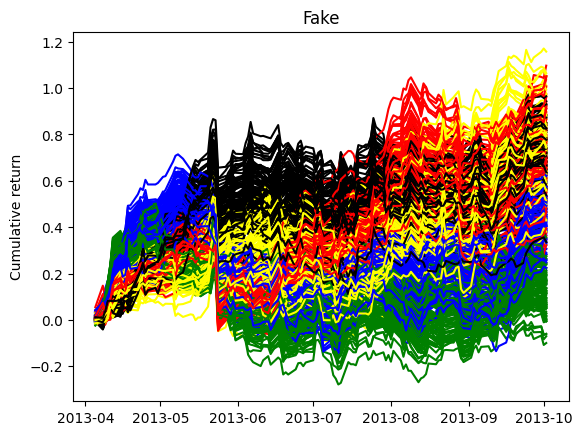

In [103]:
from gan_train_loop_MLP import plot_gan, generate_samples


for i in range(100):
    
    gen = generate_samples(generator, dataloader.dataset.assets)
    gen = gen.set_index(df_returns_real.index[:WINDOW_SIZE]).cumsum()
    for asset, color in zip(dataloader.dataset.assets, ['green', 'yellow', 'blue', 'red', 'black']):
        plt.plot(gen[asset], color=color)
        plt.title('Fake')
        plt.ylabel('Cumulative return')



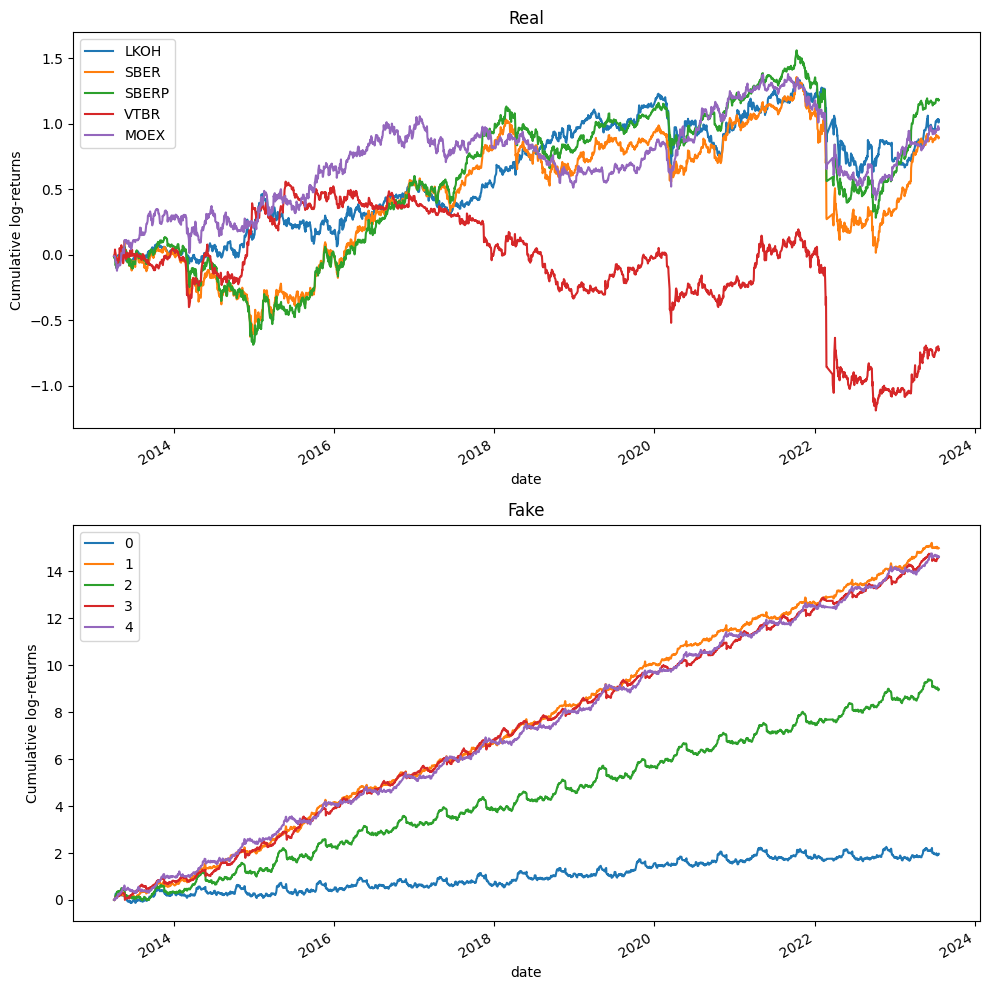

In [77]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

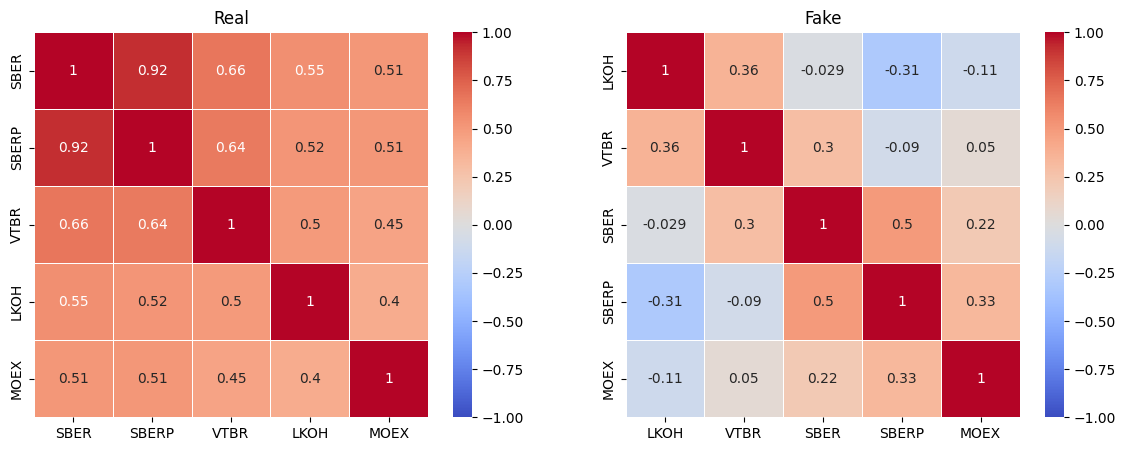

In [21]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Battlefield

In [26]:
from gan_train_loop_MLP import load_gan

generator = Generator().to(DEVICE)
load_gan('MLP', generator, epoch=300)

models\MLP
Load 300 epoch checkpoint
models\MLP\checkpoint_300


In [27]:
from generation_MLP import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

(2576, 5)
2451 torch.Size([2451, 630])
2451
shape after merg (2576, 5)


In [33]:
Generator.get_shifted_noise(1).shape

torch.Size([1, 1260])

In [ ]:
from generation_MLP import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)